In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
df = pd.read_csv('data\FAOSTAT_animal_2023.csv')

# Subset the data for Ethiopia Sheep and Ethiopia Goat
ethiopia_sheep = df[(df['Area'] == 'Ethiopia') & (df['Item'] == 'Sheep')]
ethiopia_goat = df[(df['Area'] == 'Ethiopia') & (df['Item'] == 'Goats')]

# Function to prepare the data for LSTM model
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Function to train LSTM model
def train_lstm(data, time_steps=10):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))

    # Prepare the data
    X, y = prepare_data(data_scaled, time_steps)

    # Reshape input to be [samples, time steps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X, y, epochs=20, batch_size=32, verbose=1)

    return model, scaler

# Train LSTM models for Sheep and Goats
sheep_population = ethiopia_sheep['Value'].values
goat_population = ethiopia_goat['Value'].values

sheep_model, sheep_scaler = train_lstm(sheep_population)
goat_model, goat_scaler = train_lstm(goat_population)

print("LSTM models trained successfully for Sheep and Goats population prediction in Ethiopia.")


Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.3559
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 0.3133
Epoch 3/20
1/1 [==============================] - 0s 19ms/step - loss: 0.2729
Epoch 4/20
1/1 [==============================] - 0s 19ms/step - loss: 0.2339
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 0.1959
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 0.1590
Epoch 7/20
1/1 [==============================] - 0s 39ms/step - loss: 0.1234
Epoch 8/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0899
Epoch 9/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0597
Epoch 10/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0345
Epoch 11/20
1/1 [==============================] - 0s 20ms/step - loss: 0.0170
Epoch 12/20
1/1 [==============================] - 0s 19ms/step - loss: 0.0100
Epoch 13/20
1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 1s 777ms/step


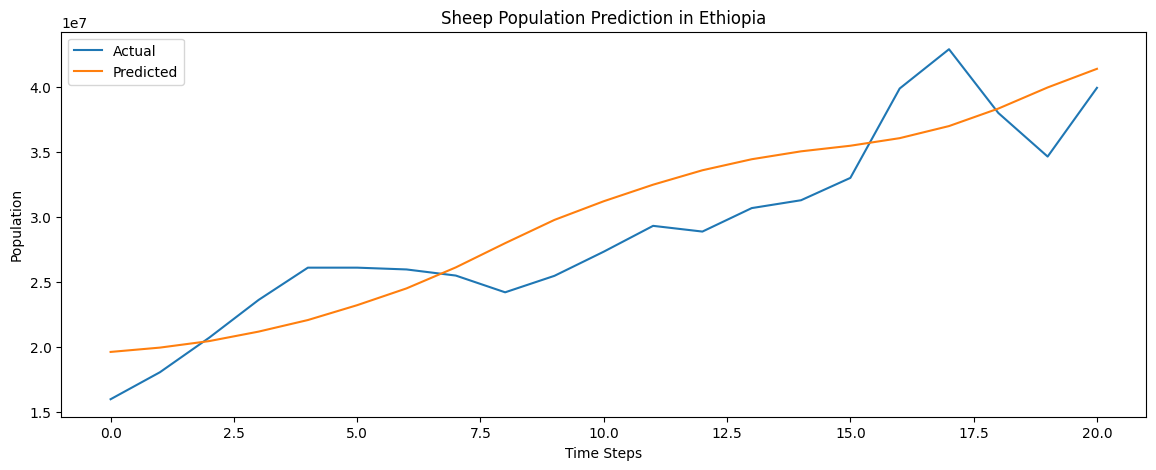

1/1 [==============================] - 1s 704ms/step


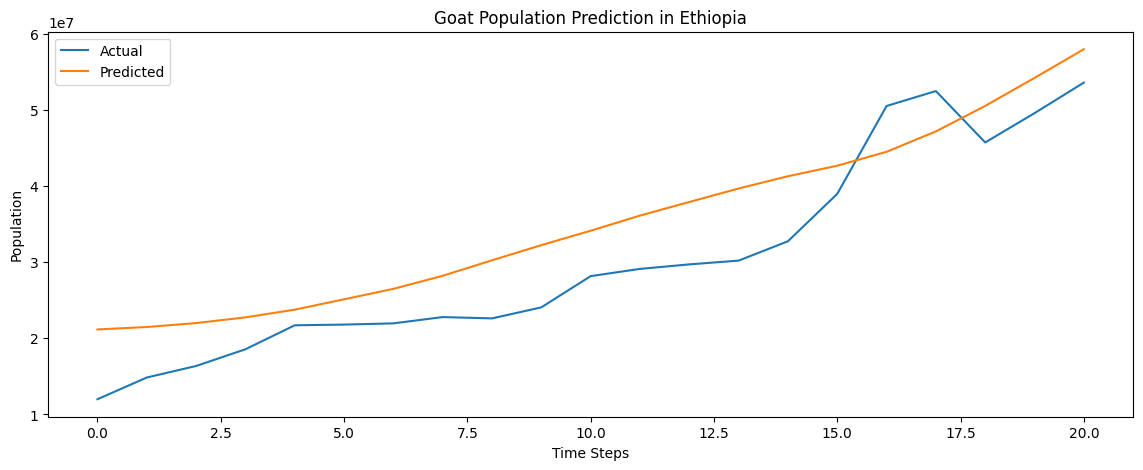

In [2]:
import matplotlib.pyplot as plt

# Function to plot the performance of the LSTM model
def plot_performance(model, data, scaler, title):
    # Normalize the data
    data_scaled = scaler.transform(data.reshape(-1, 1))

    # Prepare the data
    time_steps = 10
    X, y = prepare_data(data_scaled, time_steps)

    # Reshape input to be [samples, time steps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Predict the values
    predictions = model.predict(X)

    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y = scaler.inverse_transform(y)

    # Plot the results
    plt.figure(figsize=(14, 5))
    plt.plot(y, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

# Plot performance for Sheep and Goats
plot_performance(sheep_model, sheep_population, sheep_scaler, 'Sheep Population Prediction in Ethiopia')
plot_performance(goat_model, goat_population, goat_scaler, 'Goat Population Prediction in Ethiopia')


In [9]:
# Function to forecast future values using the LSTM model
def forecast(model, data, scaler, steps=10):
    # Normalize the data
    data_scaled = scaler.transform(data.reshape(-1, 1))

    # Prepare the data for forecasting
    forecast_data = data_scaled[-steps:].reshape((1, steps, 1))

    # Forecast future values
    forecasts = []
    for _ in range(steps):
        prediction = model.predict(forecast_data)
        forecasts.append(prediction[0, 0])
        forecast_data = np.append(forecast_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Inverse transform the forecasts
    forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

    return forecasts

# Forecast future values for Sheep and Goats
sheep_forecast = forecast(sheep_model, sheep_population, sheep_scaler, steps=10)
goat_forecast = forecast(goat_model, goat_population, goat_scaler, steps=10)

# Create a DataFrame with 2023 value and forecasts for 2024-2033
years = list(range(2023, 2034))
sheep_values = np.append(sheep_population[-1], sheep_forecast)
goat_values = np.append(goat_population[-1], goat_forecast)

forecast_df = pd.DataFrame({
    'Year': years,
    'Sheep_Population': sheep_values,
    'Goat_Population': goat_values
})


forecast_df


1/1 [==============================] - 0s 19ms/step


,Year,Sheep_Population,Goat_Population
0,2023,39946177.0,53572317.0
1,2024,42706324.0,61464240.0
2,2025,43919456.0,65378380.0
3,2026,45315408.0,69719120.0
4,2027,46636236.0,74450880.0
5,2028,48010240.0,79251144.0
6,2029,49312392.0,83630992.0
7,2030,50022364.0,86988696.0
8,2031,50565092.0,90560584.0
9,2032,51723196.0,95231104.0


In [10]:
# Function to forecast future values using the LSTM model and calculate confidence intervals
def forecast_with_ci(model, data, scaler, steps=10, ci_multiplier=1.96):
    # Normalize the data
    data_scaled = scaler.transform(data.reshape(-1, 1))

    # Prepare the data for forecasting
    forecast_data = data_scaled[-steps:].reshape((1, steps, 1))

    # Forecast future values and calculate confidence intervals
    forecasts = []
    ci_min = []
    ci_max = []
    for _ in range(steps):
        prediction = model.predict(forecast_data)
        forecasts.append(prediction[0, 0])
        
        # Calculate confidence intervals
        ci_range = ci_multiplier * np.std(prediction)
        ci_min.append(prediction[0, 0] - ci_range)
        ci_max.append(prediction[0, 0] + ci_range)
        
        forecast_data = np.append(forecast_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Inverse transform the forecasts and confidence intervals
    forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()
    ci_min = scaler.inverse_transform(np.array(ci_min).reshape(-1, 1)).flatten()
    ci_max = scaler.inverse_transform(np.array(ci_max).reshape(-1, 1)).flatten()

    return forecasts, ci_min, ci_max

# Forecast future values and confidence intervals for Sheep and Goats
sheep_forecast, sheep_ci_min, sheep_ci_max = forecast_with_ci(sheep_model, sheep_population, sheep_scaler, steps=10)
goat_forecast, goat_ci_min, goat_ci_max = forecast_with_ci(goat_model, goat_population, goat_scaler, steps=10)

# Create a DataFrame with 2023 value and forecasts for 2024-2033 including confidence intervals
years = list(range(2023, 2034))
sheep_values = np.append(sheep_population[-1], sheep_forecast)
goat_values = np.append(goat_population[-1], goat_forecast)
sheep_ci_min_values = np.append(sheep_population[-1], sheep_ci_min)
sheep_ci_max_values = np.append(sheep_population[-1], sheep_ci_max)
goat_ci_min_values = np.append(goat_population[-1], goat_ci_min)
goat_ci_max_values = np.append(goat_population[-1], goat_ci_max)

forecast_df = pd.DataFrame({
    'Year': years,
    'Sheep_Population': sheep_values,
    'Sheep_CI_Min': sheep_ci_min_values,
    'Sheep_CI_Max': sheep_ci_max_values,
    'Goat_Population': goat_values,
    'Goat_CI_Min': goat_ci_min_values,
    'Goat_CI_Max': goat_ci_max_values
})
forecast_df

1/1 [==============================] - 0s 29ms/step


,Year,Sheep_Population,Sheep_CI_Min,Sheep_CI_Max,Goat_Population,Goat_CI_Min,Goat_CI_Max
0,2023,39946177.0,3.994618e+07,3.994618e+07,53572317.0,5.357232e+07,5.357232e+07
1,2024,42706324.0,4.270632e+07,4.270632e+07,61464240.0,6.146424e+07,6.146424e+07
2,2025,43919456.0,4.391945e+07,4.391945e+07,65378380.0,6.537838e+07,6.537838e+07
3,2026,45315408.0,4.531541e+07,4.531541e+07,69719120.0,6.971913e+07,6.971913e+07
4,2027,46636236.0,4.663623e+07,4.663623e+07,74450880.0,7.445088e+07,7.445088e+07
5,2028,48010240.0,4.801024e+07,4.801024e+07,79251144.0,7.925115e+07,7.925115e+07
6,2029,49312392.0,4.931239e+07,4.931239e+07,83630992.0,8.363099e+07,8.363099e+07
7,2030,50022364.0,5.002236e+07,5.002236e+07,86988696.0,8.698870e+07,8.698870e+07
8,2031,50565092.0,5.056509e+07,5.056509e+07,90560584.0,9.056058e+07,9.056058e+07
9,2032,51723196.0,5.172320e+07,5.172320e+07,95231104.0,9.523110e+07,9.523110e+07


In [11]:
# Convert numbers to integers and format them without decimals or scientific notation
forecast_df['Sheep_Population'] = forecast_df['Sheep_Population'].apply(lambda x: '{:.0f}'.format(x))
forecast_df['Sheep_CI_Min'] = forecast_df['Sheep_CI_Min'].apply(lambda x: '{:.0f}'.format(x))
forecast_df['Sheep_CI_Max'] = forecast_df['Sheep_CI_Max'].apply(lambda x: '{:.0f}'.format(x))
forecast_df['Goat_Population'] = forecast_df['Goat_Population'].apply(lambda x: '{:.0f}'.format(x))
forecast_df['Goat_CI_Min'] = forecast_df['Goat_CI_Min'].apply(lambda x: '{:.0f}'.format(x))
forecast_df['Goat_CI_Max'] = forecast_df['Goat_CI_Max'].apply(lambda x: '{:.0f}'.format(x))
forecast_df

,Year,Sheep_Population,Sheep_CI_Min,Sheep_CI_Max,Goat_Population,Goat_CI_Min,Goat_CI_Max
0,2023,39946177,39946177,39946177,53572317,53572317,53572317
1,2024,42706324,42706321,42706321,61464240,61464240,61464240
2,2025,43919456,43919453,43919453,65378380,65378382,65378382
3,2026,45315408,45315408,45315408,69719120,69719126,69719126
4,2027,46636236,46636234,46636234,74450880,74450879,74450879
5,2028,48010240,48010240,48010240,79251144,79251145,79251145
6,2029,49312392,49312389,49312389,83630992,83630994,83630994
7,2030,50022364,50022364,50022364,86988696,86988696,86988696
8,2031,50565092,50565091,50565091,90560584,90560584,90560584
9,2032,51723196,51723196,51723196,95231104,95231104,95231104
